In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
import pandas as pd
import random
from collections import deque
import random

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/'
os.chdir(path)

from Scripts.rl_glue_horde import RLGlueHorde
from Scripts.toy_env_horde import ToyEnvironment
from Scripts.MC.monteCarloHorde import MonteCarloHorde
from Scripts.utils import bernouilli_cumulant, gaussian_cumulant, wall_detector_cumulant, gvd_based_cumulant, ReplayBuffer
from Scripts.utils import plot_q_values

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Notebooks/KME'
os.chdir(path)

In [2]:
def run_experiment(horde_info, 
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = MonteCarloHorde
    rl_glue = RLGlueHorde(env, horde)

    rl_glue.rl_init(horde_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
    
    return rl_glue

In [3]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
random.seed(50)
policy_3 = np.zeros((6*10, 4))
policy_3[:,1] = 1

GVD_1 = {
    "control": False,
    "policy" : policy,
    "transition_gen" : gaussian_cumulant,
    "transition_gen_params" : {}}

horde_info = {
    "GVDs_info" : [GVD_1],
    "num_quantiles" : 51,
    "policy" : policy,
}

# 1st Kernel

In [5]:
def get_kernel_state_action_features(state, action):
    num_actions = 4
    a_v = np.zeros(num_actions)
    a_v[action] = 1
    s_v = np.array([(state//10)/6, (state%10)/10])
    phi = np.hstack([s_v, a_v])
    return phi

In [8]:
get_kernel_state_action_features2(23,3)

array([ 0.33333333,  0.3       ,  0.        , -1.        ])

In [62]:
def computeStateActionKernelMatrix(GVF, sigma = 1):
    num_actions = 4
    dim_state = 2
    actions = gvf.actions
    states = gvf.states
    n_ = len(actions)
    p_ = dim_state + num_actions
    state_action_features = np.zeros((p_,n_))
    count = 0
    for action, state in zip(actions, states):
        state_action_features[:,count] = get_kernel_state_action_features(state, int(action))
        count +=1
    dotMatrix = np.dot(state_action_features.T, state_action_features)
    v = np.diag(dotMatrix)
    horizonTile = np.tile(v, (len(v), 1))
    distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
    kernelMatrix = np.exp(-distMatrix/sigma**2)
    return kernelMatrix

In [11]:
def computeBeta(GVF, state, action, sigma = 0.1, reg = 0.001):
    
    ## compute State Action Kernel Matrix
    num_actions = 4
    dim_state = 2
    actions = gvf.actions
    states = gvf.states
    n_ = len(actions)
    p_ = dim_state + num_actions
    state_action_features = np.zeros((p_,n_))
    count = 0
    for a, s in zip(actions, states):
        state_action_features[:,count] = get_kernel_state_action_features(s, int(a))
        count +=1
    dotMatrix = np.dot(state_action_features.T, state_action_features)
    v = np.diag(dotMatrix)
    horizonTile = np.tile(v, (len(v), 1))
    distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
    kernelMatrix = np.exp(-distMatrix/sigma**2)
    
    ## compute state_action_feature
    state_action_feature = get_kernel_state_action_features(state, action)
    k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
    k_x = np.exp(-k_x/sigma**2)
    Beta = np.dot(np.linalg.inv(kernelMatrix + n_*reg*np.diag(np.ones(n_))), k_x)
    
    return Beta
    

In [12]:
rl = run_experiment(horde_info, num_episodes= 10)
gvf = rl.horde.GVDs[0]

In [26]:
sigma = 1
actions = gvf.last_actions
returns = gvf.returns
reg = 1/(len(actions)*10)

In [27]:
## compute State Action Kernel Matrix
num_actions = 4
dim_state = 2
actions = gvf.last_actions
states = gvf.last_states
n_ = len(actions)
p_ = dim_state + num_actions
state_action_features = np.zeros((p_,n_))
count = 0
for a, s in zip(actions, states):
    state_action_features[:,count] = get_kernel_state_action_features(s, int(a))
    count +=1
dotMatrix = np.dot(state_action_features.T, state_action_features)
v = np.diag(dotMatrix)
horizonTile = np.tile(v, (len(v), 1))
distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
kernelMatrix = np.exp(-distMatrix/sigma**2)
inv = np.linalg.inv(kernelMatrix + n_*reg*np.diag(np.ones(n_)))

In [28]:
distMatrix

array([[0.        , 2.02777778, 0.02777778, ..., 0.80444444, 3.05444444,
        3.18444444],
       [2.02777778, 0.        , 2.        , ..., 2.61      , 0.80444444,
        0.93444444],
       [0.02777778, 2.        , 0.        , ..., 0.61      , 2.80444444,
        2.93444444],
       ...,
       [0.80444444, 2.61      , 0.61      , ..., 0.        , 2.02777778,
        2.03777778],
       [3.05444444, 0.80444444, 2.80444444, ..., 2.02777778, 0.        ,
        0.01      ],
       [3.18444444, 0.93444444, 2.93444444, ..., 2.03777778, 0.01      ,
        0.        ]])

In [29]:
distMatrixes = np.zeros((60, 4))

In [30]:
gvf.setDataFrame()
df = gvf.df

In [31]:
# compute state_action_feature for each state action
for state in range(60):
    for action in range(4):
        state_action_feature = get_kernel_state_action_features(state, action)
        k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
        k_x = np.exp(-k_x/sigma)
        Beta = np.dot(inv, k_x)
        q_values[state, action] = np.sum(Beta*returns)

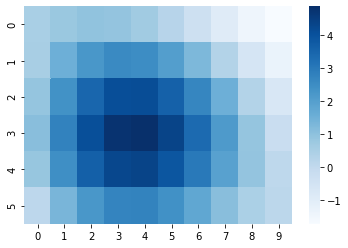

In [32]:
q0 = q_values[:, 0]
q1 = q_values[:, 1]
q2 = q_values[:, 2]
q3 = q_values[:, 3]

h0 = sns.heatmap(q0.reshape(6,10), cmap = "Blues")

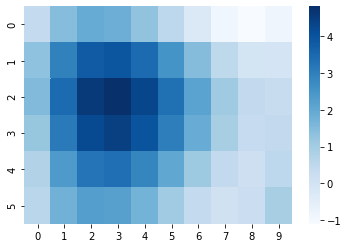

In [33]:
h1 = sns.heatmap(q1.reshape(6,10), cmap = "Blues")

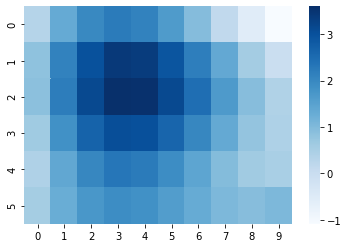

In [34]:
h2 = sns.heatmap(q2.reshape(6,10), cmap = "Blues")

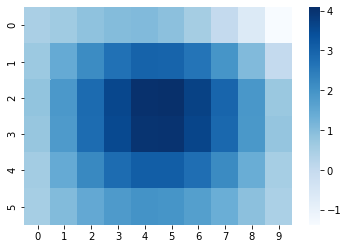

In [35]:
h3 = sns.heatmap(q3.reshape(6,10), cmap = "Blues")

In [36]:
## compute state_action_feature for each state action
state = 23
action = 1
state_action_feature = get_kernel_state_action_features(state, action)
k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
k_x = np.exp(-k_x/sigma)
Beta = np.dot(inv, k_x)
q_values[state, action] = np.sum(Beta*returns)

In [53]:
ind = Beta > 0.001

In [47]:
mask = (df['last_state'] == 23)&(df['last_action'] == 1)&(ind)

In [69]:
#df.loc[mask]

# 2nd Kernel

In [4]:
def get_kernel_state_action_features2(state, action, weight_a = 2):
    a_v = np.zeros(2)
    if action == 0:
        a_v[0] = 1
    elif action == 1:
        a_v[1] = 1
    elif action == 2:
        a_v[0] = -1
    elif action == 3:
        a_v[1] = -1
        
    a_v = a_v*weight_a
    
    s_v = np.array([(state//10), (state%10)])
    phi = np.hstack([s_v, a_v])
    return phi

In [5]:
rl = run_experiment(horde_info, num_episodes= 20)
gvf = rl.horde.GVDs[0]

In [35]:
sigma = 5
actions = gvf.last_actions
returns = gvf.returns
reg = 1/(len(actions)*10)

In [36]:
## compute State Action Kernel Matrix
dim_actions = 2
dim_state = 2
actions = gvf.last_actions
states = gvf.last_states
n_ = len(actions)
p_ = dim_state + dim_actions
state_action_features = np.zeros((p_,n_))
count = 0
for a, s in zip(actions, states):
    state_action_features[:,count] = get_kernel_state_action_features2(s, int(a))
    count +=1
dotMatrix = np.dot(state_action_features.T, state_action_features)
v = np.diag(dotMatrix)
horizonTile = np.tile(v, (len(v), 1))
distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
kernelMatrix = np.exp(-distMatrix/sigma**2)
inv = np.linalg.inv(kernelMatrix + n_*reg*np.diag(np.ones(n_)))

In [37]:
q_values = np.zeros((60, 4))

In [38]:
# compute state_action_feature for each state action
for state in range(60):
    for action in range(4):
        state_action_feature = get_kernel_state_action_features2(state, action)
        k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
        k_x = np.exp(-k_x/sigma**2)
        Beta = np.dot(inv, k_x)
        q_values[state, action] = np.sum(Beta*returns)

In [ ]:
q 

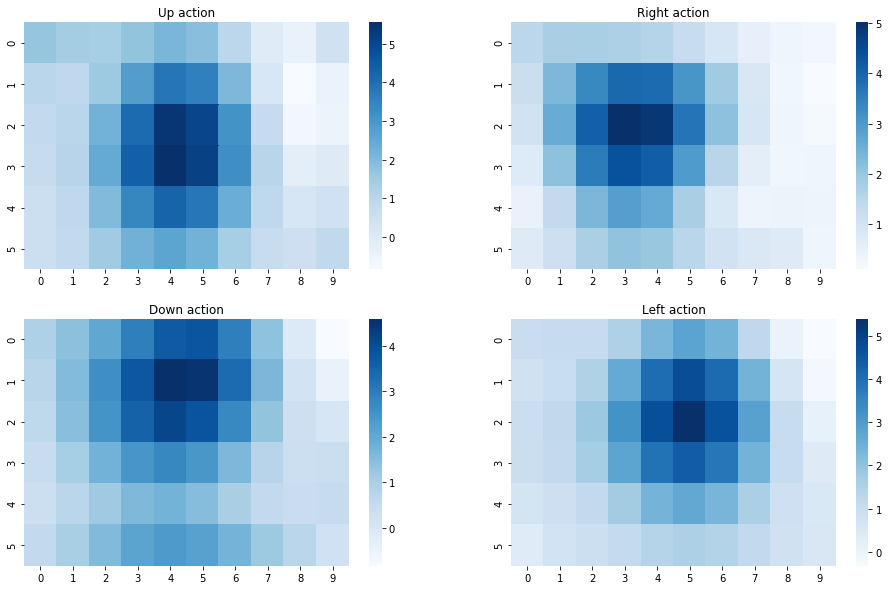

In [68]:
sigma = 5
q_values = np.load("results/q_sigma_{}.npy".format(sigma))
plot_q_values(q_values)
plt.savefig("results/q_sigma_{}.png".format(sigma), dpi = 300)

In [40]:
v = np.mean(q_values, -1)
np.save("results/q_sigma_{}".format(sigma), q_values)
np.save("results/v_sigma_{}".format(sigma), v)

In [6]:
mc_df = pd.read_csv('../GVD/results/monte_carlo/gaussian_policy_on_policy_returns')

In [7]:
def get_returns(dataframe, last_state, last_action):
    mask = (dataframe["last_state"] == last_state)&(dataframe["last_action"] == last_action)
    return np.array(dataframe.loc[mask, "return"])

In [8]:
q_ref = np.zeros((60,4))
for s in range(60):
    for a in range(4):
        z = get_returns(mc_df, s, a)
        q_ref[s,a] = np.mean(z)

/Users/louisserrano/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/louisserrano/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
np.save("results/q_ref", q_ref)

In [14]:
v_ref = np.mean(q_ref, -1)

In [47]:
def calc_RMSVE(learned_state_val, true_state_val, state_distribution):
    learned_state_val = np.squeeze(learned_state_val.reshape(-1, 1), -1)
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    learned_state_val = np.nan_to_num(learned_state_val)
    true_state_val = np.nan_to_num(true_state_val)
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

In [41]:
dist = rl.horde.horde_message("get state distribution", 1)

In [43]:
np.save("results/state_distrib", dist)

In [48]:
calc_RMSVE(v, v_ref, dist)

0.3490036569087768

In [51]:
RMSVEs = []
for sigma in [0.5, 1, 2, 5]:
    v = np.load("results/v_sigma_{}.npy".format(sigma))
    rmsve = calc_RMSVE(v, v_ref, dist)
    RMSVEs.append(rmsve)

In [58]:
df = pd.DataFrame({"rmsve" : RMSVEs})

In [63]:
df.to_csv('results/RMSVE.csv', index = False)

In [69]:
df

,rmsve
0,0.257864
1,0.258269
2,0.257312
3,0.349004
